In [7]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib as mpl

In [6]:
# 한글 폰트 설정 (필요시)
import matplotlib.font_manager as fm
# font_path = 'C:/Windows/Fonts/malgun.ttf'  # 맑은 고딕 경로 (Windows)
# font_name = fm.FontProperties(fname=font_path).get_name()
# plt.rc('font', family=font_name)
# plt.rc('axes', unicode_minus=False)  # 마이너스 기호 깨짐 방지

mpl.rc('font', family='AppleGothic')  # macOS 기본 한글 지원 폰트
mpl.rcParams['axes.unicode_minus'] = False

In [9]:
# # 데이터 로드
# df = pd.read_csv('nightlife_crime.csv', encoding='cp949')

df = pd.read_csv('nightlife_crime.csv')

In [10]:
# 데이터 구조 확인
print("데이터 구조:", df.shape)
print("컬럼명:", df.columns.tolist())

데이터 구조: (25, 14)
컬럼명: ['region', 'pub', 'karaoke', 'tot_nightlife', 'murder', 'robbery', 'forcible_rape', 'thef', 'violence', 'murder_tot', 'robbery_Tot', 'forcible_rape_Tot', 'thef_tot', 'violence_Tot']


In [11]:
# 청소년 범죄율 계산
crime_types = {
    'murder': 'murder_tot', 
    'robbery': 'robbery_Tot', 
    'forcible_rape': 'forcible_rape_Tot',
    'thef': 'thef_tot', 
    'violence': 'violence_Tot'
}


In [12]:
# 모든 범죄 유형별 청소년 비율 계산
for youth, total in crime_types.items():
    df[f'{youth}_ratio'] = df[youth] / df[total]

In [13]:
# 전체 청소년 범죄 비율 (청소년 범죄 합계/전체 범죄 합계)
df['total_youth'] = df['murder'] + df['robbery'] + df['forcible_rape'] + df['thef'] + df['violence']
df['total_crime'] = df['murder_tot'] + df['robbery_Tot'] + df['forcible_rape_Tot'] + df['thef_tot'] + df['violence_Tot']
df['total_youth_ratio'] = df['total_youth'] / df['total_crime']


In [14]:
# 유흥업소 합계
df['tot_nightlife'] = df['pub'] + df['karaoke']


In [15]:
# 1단계: 비교시각화를 통한 주요인자 도출

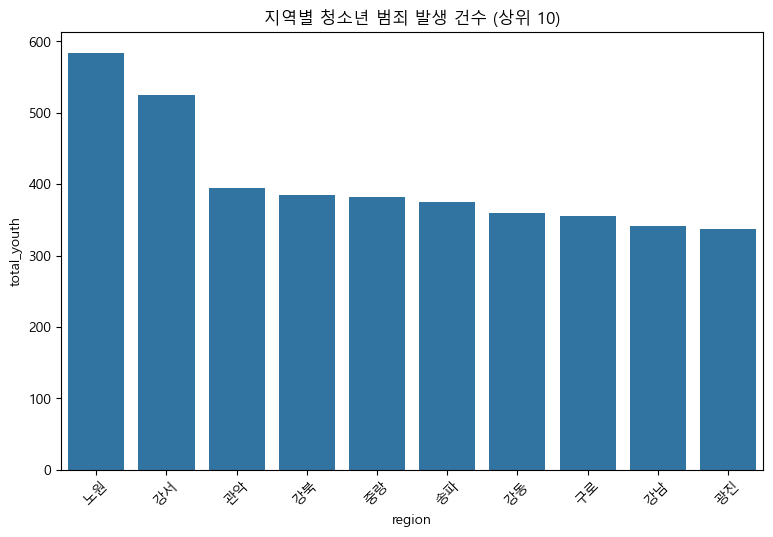

In [130]:
plt.figure(figsize=(15, 10))

# 1. 지역별 청소년 범죄 건수 비교 (상위 10개 지역)
plt.subplot(2, 2, 1)
crime_by_location = df[['region', 'total_youth']].sort_values('total_youth', ascending=False)
sns.barplot(x='region', y='total_youth', data=crime_by_location.head(10))
plt.title('지역별 청소년 범죄 발생 건수 (상위 10)')
plt.xticks(rotation=45)
plt.tight_layout()

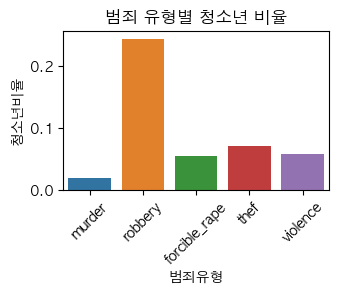

In [16]:
# 2. 범죄 유형별 청소년 비율
plt.subplot(2, 2, 2)
ratio_data = pd.DataFrame({
    '범죄유형': list(crime_types.keys()),
    '청소년비율': [df[f'{crime}_ratio'].mean() for crime in crime_types.keys()]
})
sns.barplot(x='범죄유형', y='청소년비율', data=ratio_data)
plt.title('범죄 유형별 청소년 비율')
plt.xticks(rotation=45)
plt.tight_layout()

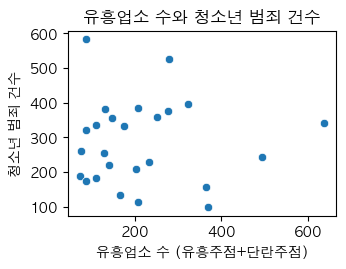

In [17]:
# 3. 유흥업소수와 청소년 범죄 산점도
plt.subplot(2, 2, 3)
sns.scatterplot(x='tot_nightlife', y='total_youth', data=df)
plt.title('유흥업소 수와 청소년 범죄 건수')
plt.xlabel('유흥업소 수 (유흥주점+단란주점)')
plt.ylabel('청소년 범죄 건수')
plt.tight_layout()

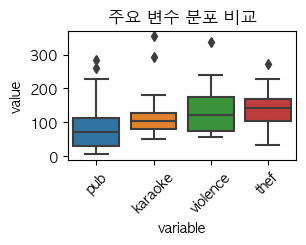

In [18]:
# 4. 박스플롯 - 주요 변수 분포
plt.subplot(2, 2, 4)
box_data = pd.melt(df[['pub', 'karaoke', 'violence', 'thef']])
sns.boxplot(x='variable', y='value', data=box_data)
plt.title('주요 변수 분포 비교')
plt.xticks(rotation=45)
plt.tight_layout()

plt.tight_layout(pad=3.0)
plt.show()

In [19]:
#--------------------------------------------
# 2단계: 관계시각화 및 상관분석
#--------------------------------------------

In [20]:
# 1. 구별 히트맵 - 청소년 범죄와 환경요인
# 분석 대상 컬럼 선택
target_cols = ['region', 'pub', 'karaoke', 'tot_nightlife',
              'murder', 'robbery', 'forcible_rape', 'thef', 'violence']

In [21]:
# 데이터 정규화
scaler = MinMaxScaler()
cols_to_scale = [col for col in target_cols if col != 'region']
df_norm = pd.DataFrame(scaler.fit_transform(df[cols_to_scale]), 
                      columns=cols_to_scale,
                      index=df['region'])

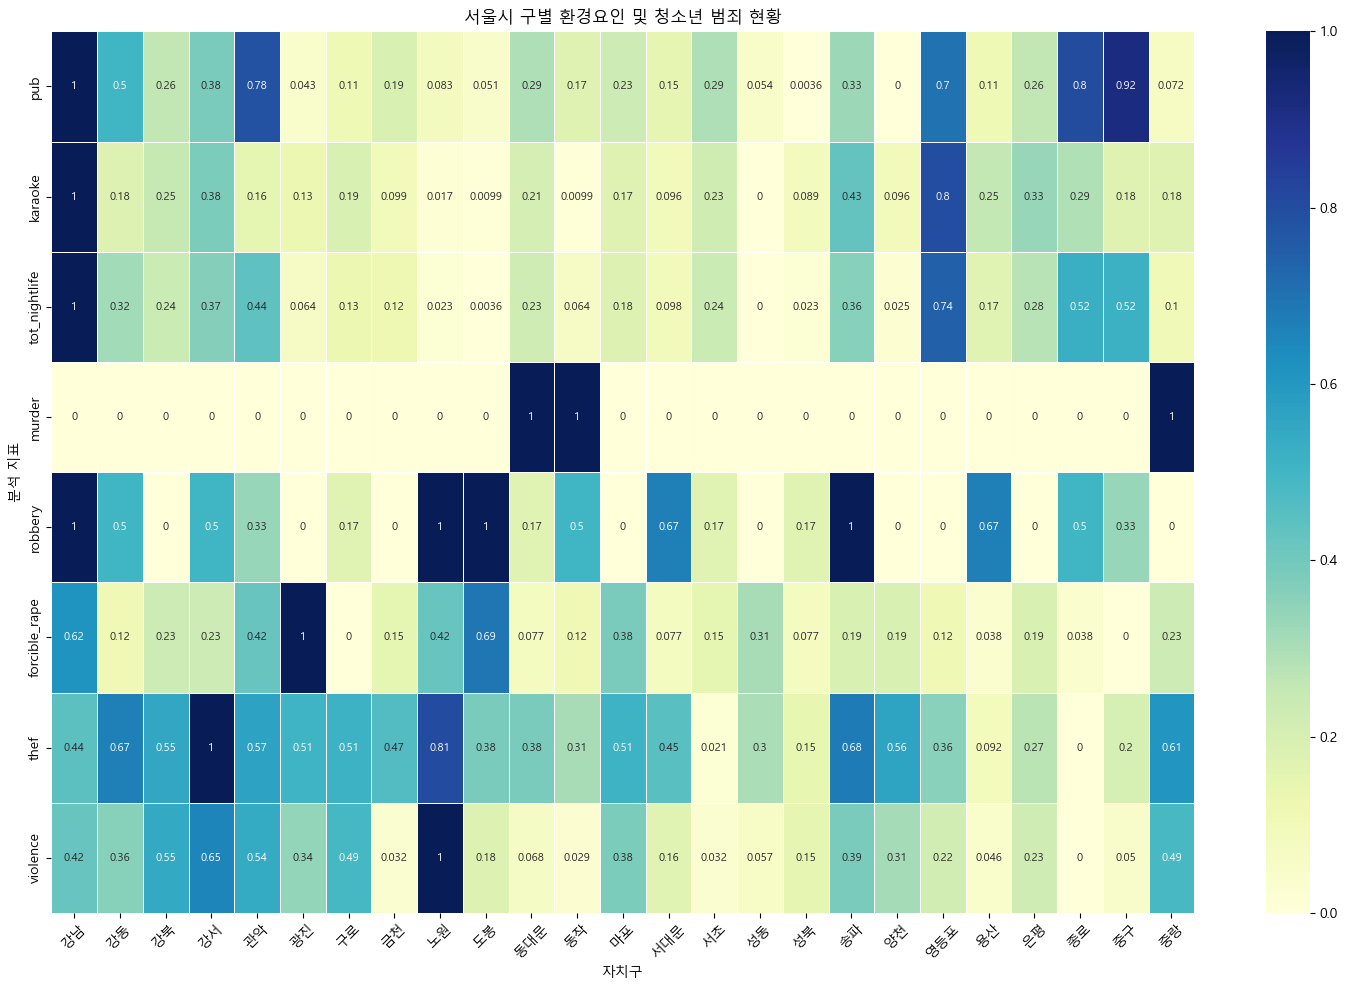

In [138]:
# 히트맵 생성
plt.figure(figsize=(15, 10))
sns.heatmap(df_norm.T, cmap='YlGnBu', annot=True, 
           linewidths=0.5, annot_kws={'size':8})
plt.title('서울시 구별 환경요인 및 청소년 범죄 현황')
plt.xlabel('자치구')
plt.ylabel('분석 지표')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

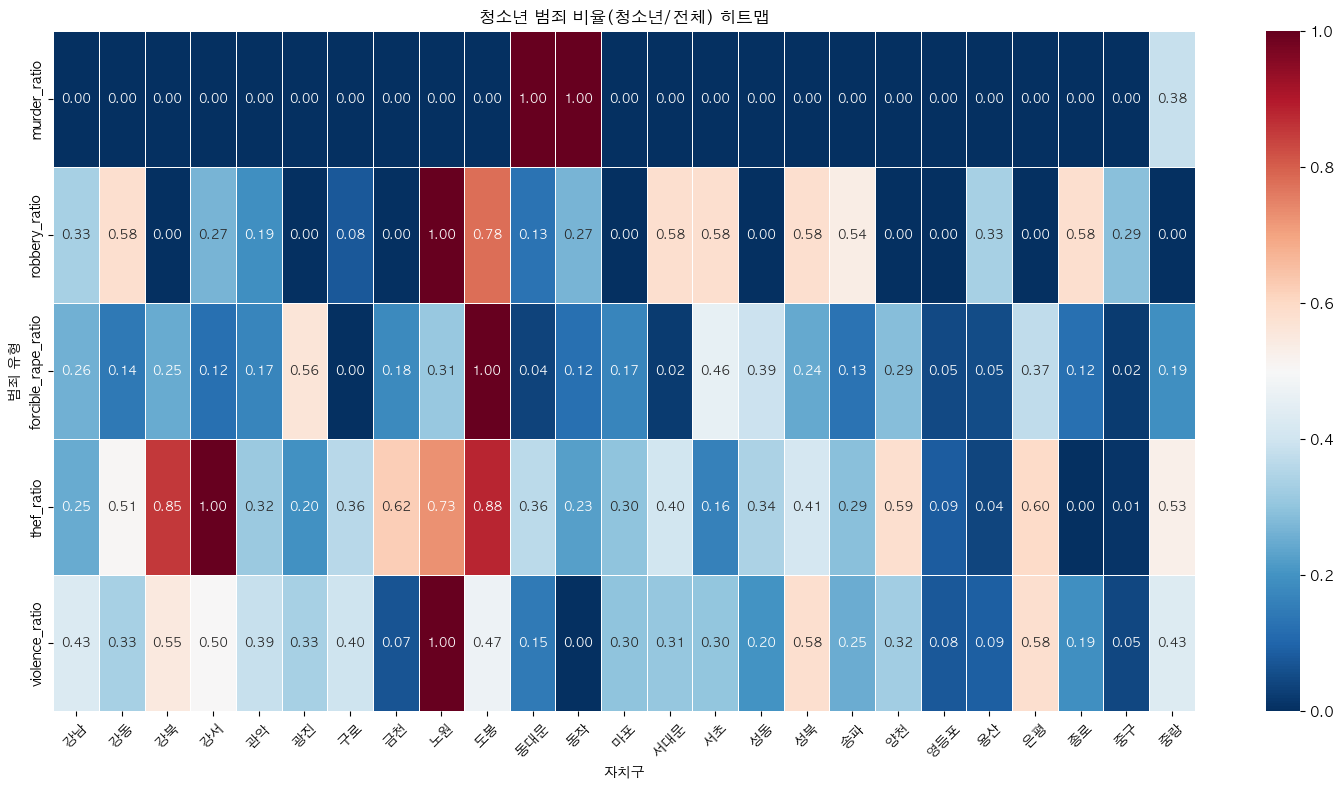

In [22]:
# 2. 청소년 범죄 비율 히트맵
ratio_cols = [f'{crime}_ratio' for crime in crime_types.keys()]
df_ratio_norm = pd.DataFrame(scaler.fit_transform(df[ratio_cols]),
                            columns=ratio_cols,
                            index=df['region'])
plt.figure(figsize=(15, 8))
sns.heatmap(df_ratio_norm.T, cmap='RdBu_r', center=0.5,
           linecolor='white', linewidths=0.5,
           annot=True, fmt='.2f',
           annot_kws={'size':9})
plt.title('청소년 범죄 비율(청소년/전체) 히트맵')
plt.xlabel('자치구')
plt.ylabel('범죄 유형')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

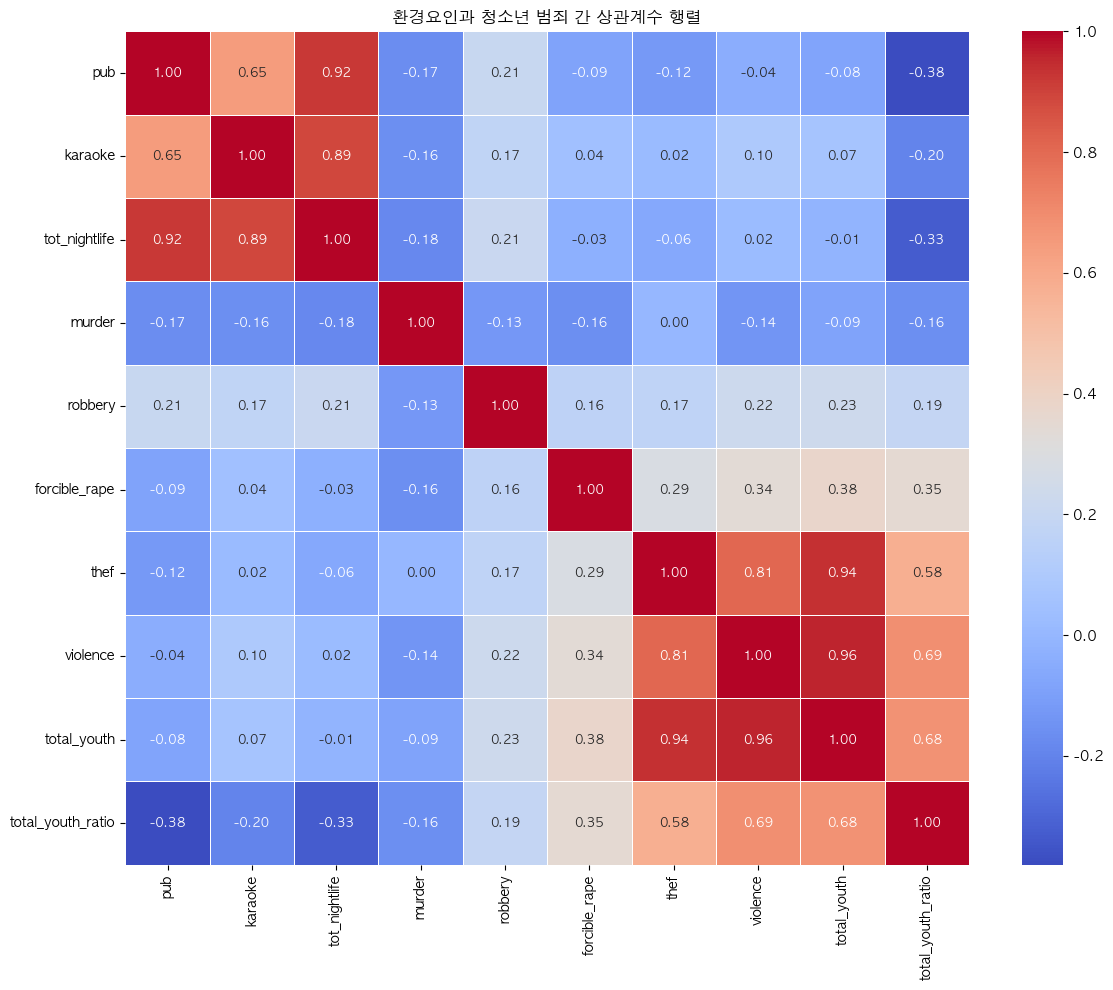

In [23]:
# 3. 상관계수 분석
correlation_vars = ['pub', 'karaoke', 'tot_nightlife', 
                  'murder', 'robbery', 'forcible_rape', 'thef', 'violence',
                  'total_youth', 'total_youth_ratio']
corr_matrix = df[correlation_vars].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
           linewidths=0.5, annot_kws={'size':9})
plt.title('환경요인과 청소년 범죄 간 상관계수 행렬')
plt.tight_layout()
plt.show()

In [24]:
# 4. 피어슨 상관계수 검정
print("\n=== 유흥업소와 청소년 범죄 상관계수 검정 ===")
for crime in ['murder', 'robbery', 'forcible_rape', 'thef', 'violence', 'total_youth']:
    r, p = stats.pearsonr(df['tot_nightlife'], df[crime])
    print(f'유흥업소-{crime} 상관계수: {r:.3f}, p-value: {p:.4f} {"(유의미)" if p < 0.05 else ""}')



=== 유흥업소와 청소년 범죄 상관계수 검정 ===
유흥업소-murder 상관계수: -0.181, p-value: 0.3871 
유흥업소-robbery 상관계수: 0.210, p-value: 0.3143 
유흥업소-forcible_rape 상관계수: -0.031, p-value: 0.8826 
유흥업소-thef 상관계수: -0.064, p-value: 0.7609 
유흥업소-violence 상관계수: 0.024, p-value: 0.9094 
유흥업소-total_youth 상관계수: -0.015, p-value: 0.9449 


In [ ]:
#--------------------------------------------
# 3단계: 회귀분석
#--------------------------------------------

In [25]:
# 다중 선형회귀 분석
print("\n=== 회귀분석 결과 ===")
# 1. 폭력범죄에 대한 회귀분석
X = df[['pub', 'karaoke']]
y = df['violence']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print("\n청소년 폭력범죄 회귀분석 결과:")
print(model.summary().tables[1])  # 간결하게 계수 부분만 출력


=== 회귀분석 결과 ===

청소년 폭력범죄 회귀분석 결과:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.9915     28.873      4.364      0.000      66.112     185.871
pub           -0.1466      0.229     -0.640      0.529      -0.621       0.328
karaoke        0.2060      0.270      0.762      0.454      -0.355       0.767


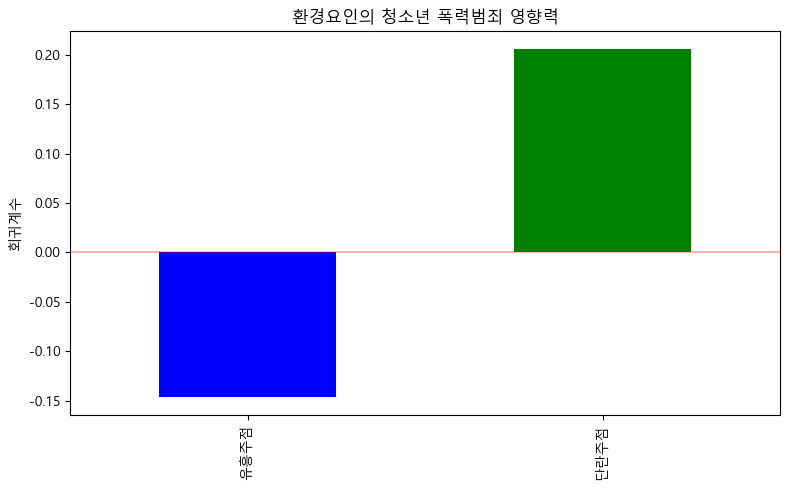

In [146]:
# 회귀계수 시각화
plt.figure(figsize=(8, 5))
model_params = model.params[1:]
model_params.index = ['유흥주점', '단란주점']
model_params.plot.bar(color=['blue', 'green'])
plt.title('환경요인의 청소년 폭력범죄 영향력')
plt.ylabel('회귀계수')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
# 2. 전체 청소년 범죄에 대한 회귀분석
X = df[['pub', 'karaoke']]
y = df['total_youth']
X = sm.add_constant(X)
model_total = sm.OLS(y, X).fit()
print("\n전체 청소년 범죄 회귀분석 결과:")
print(model_total.summary().tables[1])  # 간결하게 계수 부분만 출력


전체 청소년 범죄 회귀분석 결과:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        272.0865     51.198      5.314      0.000     165.907     378.265
pub           -0.3143      0.406     -0.774      0.447      -1.156       0.528
karaoke        0.3563      0.480      0.743      0.465      -0.638       1.351


In [ ]:
#--------------------------------------------
# 4단계: 추가 분석 (청소년 폭력-절도 관계)
#--------------------------------------------

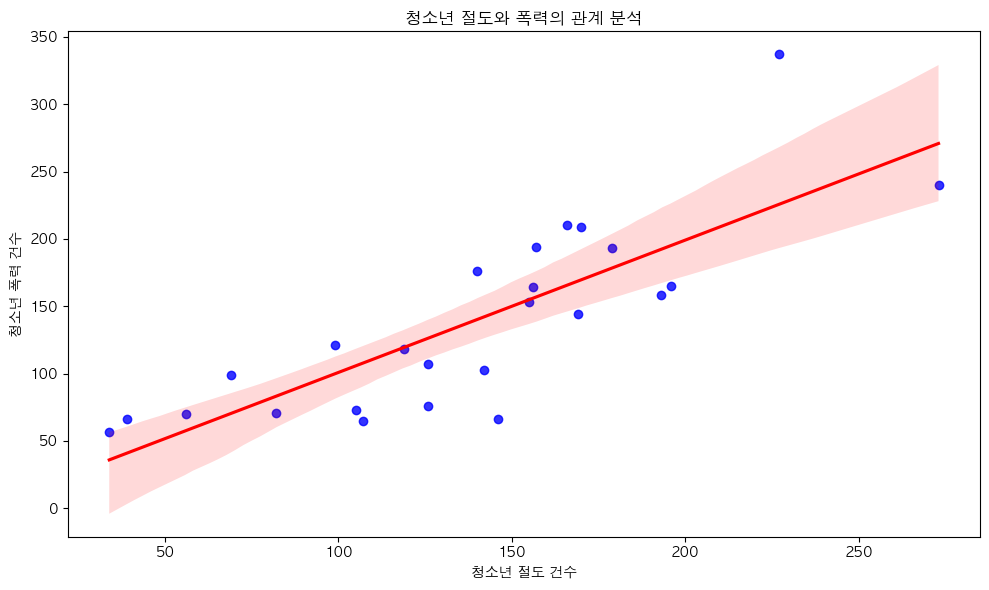

In [27]:
# 절도-폭력 관계 심층 분석
plt.figure(figsize=(10, 6))
sns.regplot(x='thef', y='violence', data=df, 
          scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('청소년 절도와 폭력의 관계 분석')
plt.xlabel('청소년 절도 건수')
plt.ylabel('청소년 폭력 건수')
plt.tight_layout()
plt.show()

In [28]:
# 절도-폭력 상관계수
r_tv, p_tv = stats.pearsonr(df['thef'], df['violence'])
print(f"\n청소년 절도-폭력 상관계수: {r_tv:.3f}, p-value: {p_tv:.4f}")

print("\n=== 가설 검증 결과 ===")
if p < 0.05:
    print("환경요인(유흥업소 수)이 청소년 범죄에 유의미한 영향을 미친다.")
else:
    print("환경요인(유흥업소 수)이 청소년 범죄에 유의미한 영향을 미친다고 볼 수 없다.")
    print("→ 단, 청소년 절도와 폭력 간에는 강한 상관관계가 있으므로 추가 분석이 필요하다.")


청소년 절도-폭력 상관계수: 0.811, p-value: 0.0000

=== 가설 검증 결과 ===
환경요인(유흥업소 수)이 청소년 범죄에 유의미한 영향을 미친다고 볼 수 없다.
→ 단, 청소년 절도와 폭력 간에는 강한 상관관계가 있으므로 추가 분석이 필요하다.
